In [46]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random
from typing import Tuple, List

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm



# EDA

In [8]:
base_skin_dir = "//Users/murad/Downloads/"
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv')) # load in the data
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
# Dictionary mapping image IDs to their respective file paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Dictionary mapping lesion types to danger levels
lesion_danger = {
    'nv': 0,     # others (0)
    'mel': 1,    # melanoma (1)
    'bkl': 0,    # others (0)
    'bcc': 0,    # others (0)
    'akiec': 0,  # others (0)
    'vasc': 0,   # others (0)
    'df': 0      # others (0)
}

# Dictionary mapping localization of skin lesions to numerical values
localization_mapping = {
    'back': 15,
    'lower extremity': 14,
    'trunk': 13,
    'upper extremity': 12,
    'abdomen': 11,
    'face': 10,
    'chest': 9,
    'foot': 8,
    'unknown': 7,
    'neck': 6,
    'scalp': 5,
    'hand': 4,
    'ear': 3,
    'genital': 2,
    'acral': 1
}

# Dictionary mapping diagnosis types to numerical values
dx_type_mapping = {
    'histo': 3,
    'follow_up': 2,
    'consensus': 1,
    'confocal': 0
}


In [10]:
# Map lesion types to danger levels and create a new column 'Melanoma'
skin_df["Melanoma"] = skin_df["dx"].map(lesion_danger.get)

# Map localization of skin lesions to numerical values and create a new column 'Localization'
skin_df["Localization"] = skin_df["localization"].map(localization_mapping.get)

# Map diagnosis types to numerical values and create a new column 'Dx_type'
skin_df['Dx_type'] = skin_df['dx_type'].map(dx_type_mapping)

# Map 'sex' column to numerical values (0 for unknown, 1 for female, 2 for male) and create a new column 'Sex'
skin_df['Sex'] = np.where(skin_df['sex'] == 'unknown', 0, np.where(skin_df['sex'] == 'female', 1, np.where(skin_df['sex'] == 'male', 2, skin_df['sex'])))

# Map image IDs to their respective file paths and create a new column 'path'
skin_df["path"] = skin_df["image_id"].map(imageid_path_dict.get) # map image_id to the path of that image


In [11]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Melanoma,Localization,Dx_type,Sex,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0,5,3,2,//Users/murad/Downloads/HAM10000_images_part_1...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0,5,3,2,//Users/murad/Downloads/HAM10000_images_part_1...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0,5,3,2,//Users/murad/Downloads/HAM10000_images_part_1...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0,5,3,2,//Users/murad/Downloads/HAM10000_images_part_1...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0,3,3,2,//Users/murad/Downloads/HAM10000_images_part_2...


In [12]:
skin_df['path'][0]

'//Users/murad/Downloads/HAM10000_images_part_1/ISIC_0027419.jpg'

In [13]:
skin_df['part'] = 'part_1'
skin_df.loc[skin_df['path'].str.contains('part_2'), 'part'] = 'part_2'

# Split the DataFrame into two based on the 'part' column
skin_df_1 = skin_df[skin_df['part'] == 'part_1'].drop(columns=['part'])
skin_df_2 = skin_df[skin_df['part'] == 'part_2'].drop(columns=['part'])

# Optional: Drop the 'part' column from the original DataFrame
skin_df = skin_df.drop(columns=['part'])

In [14]:
# Explore the basic structure of the data
skin_df.info()
skin_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   Melanoma      10015 non-null  int64  
 8   Localization  10015 non-null  int64  
 9   Dx_type       10015 non-null  int64  
 10  Sex           10015 non-null  object 
 11  path          10015 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 939.0+ KB


,age,Melanoma,Localization,Dx_type
count,9958.000000,10015.000000,10015.000000,10015.000000
mean,51.863828,0.111133,12.226660,2.429356
std,16.968614,0.314313,2.751391,0.683025
min,0.000000,0.000000,1.000000,0.000000
25%,40.000000,0.000000,11.000000,2.000000
50%,50.000000,0.000000,13.000000,3.000000
75%,65.000000,0.000000,14.000000,3.000000
max,85.000000,1.000000,15.000000,3.000000


/Users/murad/anaconda/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


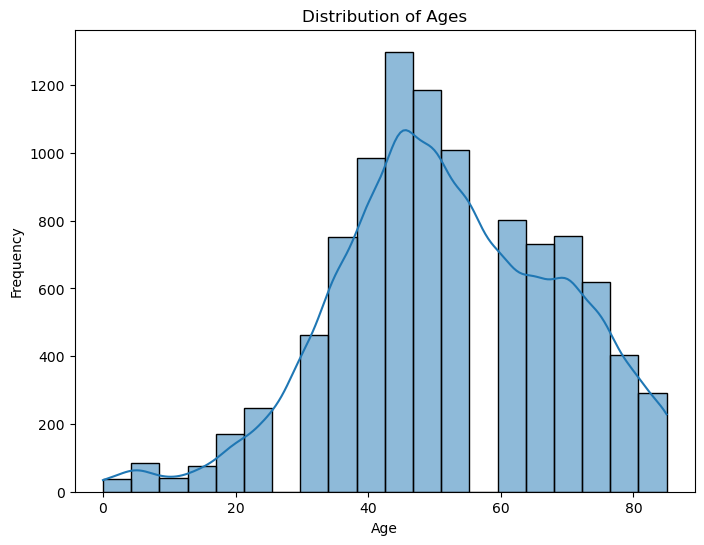

In [15]:
#Distribution of Ages
plt.figure(figsize=(8, 6))
sns.histplot(skin_df['age'], bins=20, kde=True)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

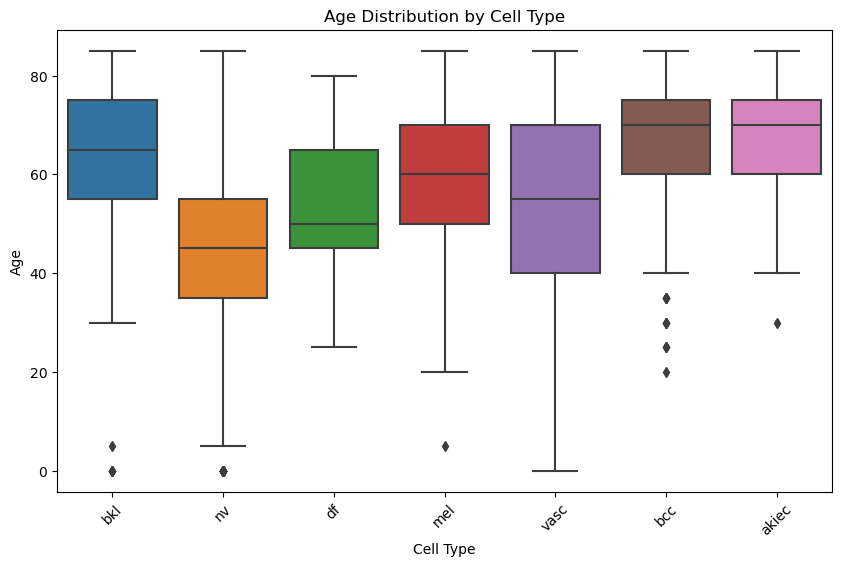

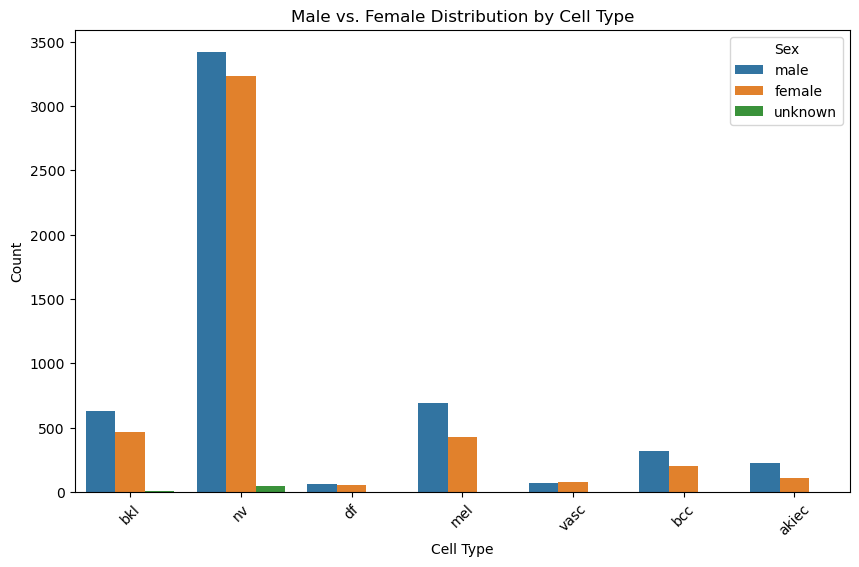

In [16]:
# Visualize age distribution by cell type
plt.figure(figsize=(10, 6))
sns.boxplot(x='dx', y='age', data=skin_df)
plt.title('Age Distribution by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

# Visualize male vs. female distribution by cell type
plt.figure(figsize=(10, 6))
sns.countplot(x='dx', hue='sex', data=skin_df)
plt.title('Male vs. Female Distribution by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()


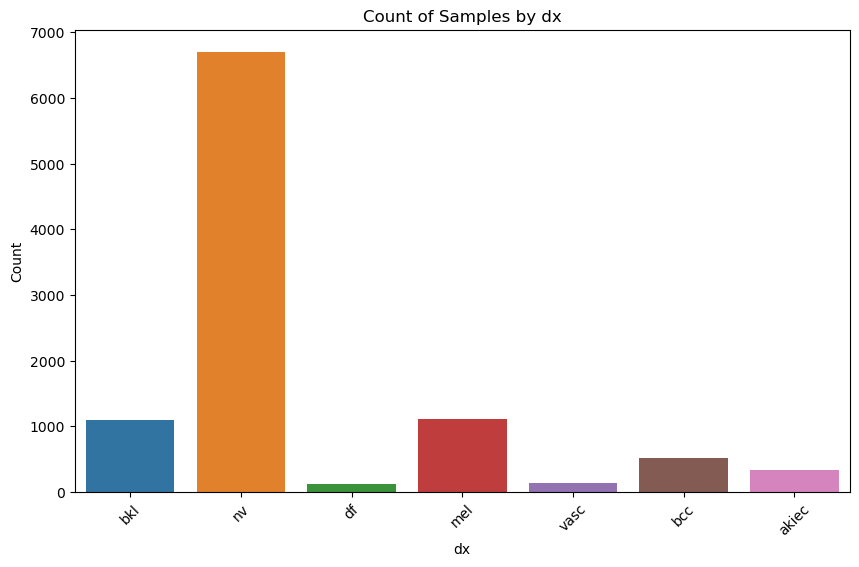

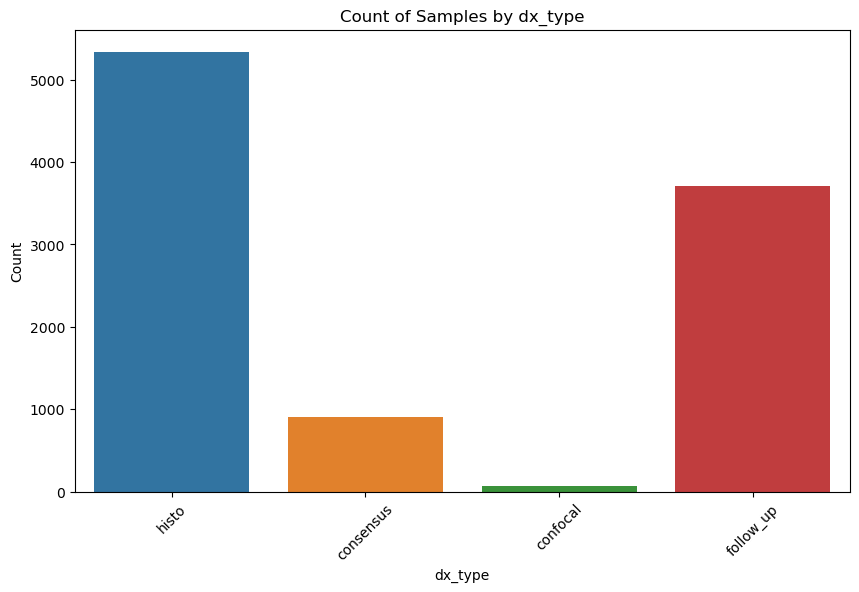

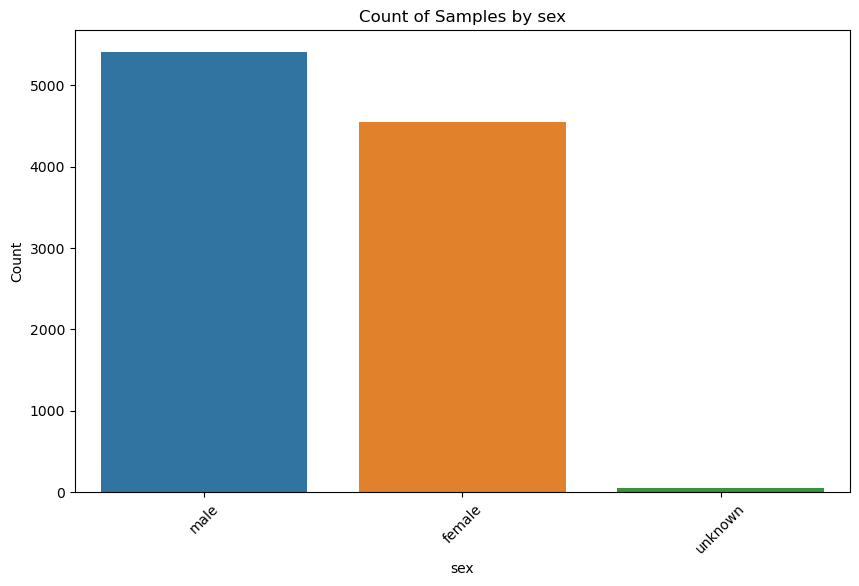

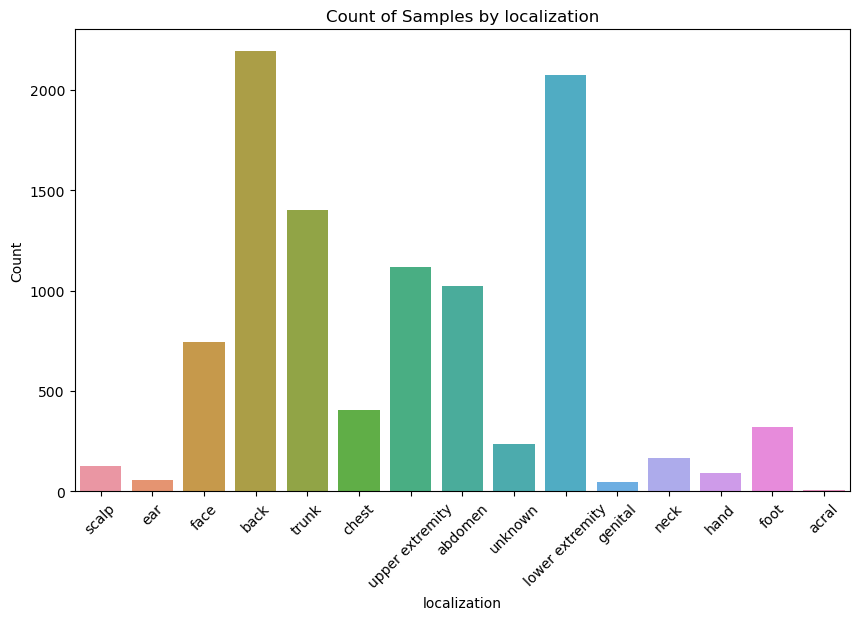

In [17]:
categorical_features = ['dx', 'dx_type', 'sex', 'localization']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=skin_df)
    plt.title(f'Count of Samples by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


# Feature Extraction

In [18]:
def extract_pixel_values(image_path, target_size=(28, 28)):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Flatten the array to get a 1D array of pixel values
    flat_array = img_array.flatten()

    return flat_array

In [20]:
def add_pixel_columns_to_df(df):
    # Create a copy of the original DataFrame to avoid modifying the input DataFrame
    df_copy = df.copy()

    # Iterate through each row in the DataFrame
    for index, row in tqdm(df_copy.iterrows()):
        # Get the image path from the 'path' column
        image_path = row['path']

        # Extract pixel values
        pixel_values = extract_pixel_values(image_path)  # You need to define the extract_pixel_values function

        # Add the pixel values as new columns to the DataFrame
        for i, pixel_value in enumerate(pixel_values):
            df_copy.loc[index, f'pixel_{i}'] = pixel_value

    return df_copy

# Call the function with the DataFrame
main_df = add_pixel_columns_to_df(skin_df)


10015it [06:28, 25.76it/s]


In [22]:
#main_df.to_csv(base_skin_dir + "main_df.csv", index=False)

In [23]:
main_df = pd.read_csv(os.path.join(base_skin_dir, 'main_df.csv')) # load in the data

In [24]:
main_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,Melanoma,Localization,Dx_type,...,pixel_2342,pixel_2343,pixel_2344,pixel_2345,pixel_2346,pixel_2347,pixel_2348,pixel_2349,pixel_2350,pixel_2351
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0,5,3,...,178.0,121.0,118.0,170.0,155.0,137.0,181.0,174.0,151.0,184.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0,5,3,...,110.0,56.0,42.0,58.0,30.0,15.0,26.0,26.0,15.0,24.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0,5,3,...,175.0,140.0,124.0,166.0,134.0,118.0,152.0,121.0,109.0,138.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0,5,3,...,87.0,33.0,23.0,40.0,16.0,12.0,24.0,16.0,12.0,24.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0,3,3,...,224.0,180.0,156.0,206.0,147.0,135.0,171.0,93.0,78.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0,11,3,...,208.0,191.0,185.0,211.0,183.0,183.0,205.0,186.0,188.0,204.0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0,11,3,...,162.0,63.0,65.0,78.0,11.0,14.0,13.0,3.0,5.0,6.0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0,11,3,...,223.0,187.0,185.0,213.0,148.0,156.0,177.0,167.0,170.0,190.0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0,10,3,...,185.0,173.0,166.0,188.0,164.0,155.0,185.0,170.0,163.0,184.0


In [25]:
sample_df = main_df.copy()
sample_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,Melanoma,Localization,Dx_type,...,pixel_2342,pixel_2343,pixel_2344,pixel_2345,pixel_2346,pixel_2347,pixel_2348,pixel_2349,pixel_2350,pixel_2351
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0,5,3,...,178.0,121.0,118.0,170.0,155.0,137.0,181.0,174.0,151.0,184.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0,5,3,...,110.0,56.0,42.0,58.0,30.0,15.0,26.0,26.0,15.0,24.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0,5,3,...,175.0,140.0,124.0,166.0,134.0,118.0,152.0,121.0,109.0,138.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0,5,3,...,87.0,33.0,23.0,40.0,16.0,12.0,24.0,16.0,12.0,24.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0,3,3,...,224.0,180.0,156.0,206.0,147.0,135.0,171.0,93.0,78.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0,11,3,...,208.0,191.0,185.0,211.0,183.0,183.0,205.0,186.0,188.0,204.0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0,11,3,...,162.0,63.0,65.0,78.0,11.0,14.0,13.0,3.0,5.0,6.0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0,11,3,...,223.0,187.0,185.0,213.0,148.0,156.0,177.0,167.0,170.0,190.0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0,10,3,...,185.0,173.0,166.0,188.0,164.0,155.0,185.0,170.0,163.0,184.0


In [26]:
def preprocess_dataframe(df):
    # Drop specified columns
    columns_to_drop = ['lesion_id', 'image_id', 'dx', 'dx_type', 'localization','path','sex']
    df = df.drop(columns=columns_to_drop, axis=1)

    # Replace missing values in 'age' column with the mean
    df['age'] = df['age'].fillna(df['age'].mean())

    return df

# Call the preprocessing function with the DataFrame
sample_df = preprocess_dataframe(sample_df)

# Display the modified DataFrame
sample_df


,age,Melanoma,Localization,Dx_type,Sex,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,...,pixel_2342,pixel_2343,pixel_2344,pixel_2345,pixel_2346,pixel_2347,pixel_2348,pixel_2349,pixel_2350,pixel_2351
0,80.0,0,5,3,2,185.0,149.0,191.0,190.0,153.0,...,178.0,121.0,118.0,170.0,155.0,137.0,181.0,174.0,151.0,184.0
1,80.0,0,5,3,2,28.0,14.0,24.0,74.0,47.0,...,110.0,56.0,42.0,58.0,30.0,15.0,26.0,26.0,15.0,24.0
2,80.0,0,5,3,2,150.0,134.0,188.0,167.0,149.0,...,175.0,140.0,124.0,166.0,134.0,118.0,152.0,121.0,109.0,138.0
3,80.0,0,5,3,2,29.0,18.0,36.0,79.0,66.0,...,87.0,33.0,23.0,40.0,16.0,12.0,24.0,16.0,12.0,24.0
4,75.0,0,3,3,2,138.0,114.0,157.0,176.0,144.0,...,224.0,180.0,156.0,206.0,147.0,135.0,171.0,93.0,78.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,40.0,0,11,3,2,197.0,181.0,194.0,200.0,182.0,...,208.0,191.0,185.0,211.0,183.0,183.0,205.0,186.0,188.0,204.0
10011,40.0,0,11,3,2,8.0,8.0,8.0,32.0,34.0,...,162.0,63.0,65.0,78.0,11.0,14.0,13.0,3.0,5.0,6.0
10012,40.0,0,11,3,2,130.0,126.0,139.0,162.0,161.0,...,223.0,187.0,185.0,213.0,148.0,156.0,177.0,167.0,170.0,190.0
10013,80.0,0,10,3,2,142.0,119.0,160.0,153.0,133.0,...,185.0,173.0,166.0,188.0,164.0,155.0,185.0,170.0,163.0,184.0


In [27]:
sample_df.isna().sum()

age             0
Melanoma        0
Localization    0
Dx_type         0
Sex             0
               ..
pixel_2347      0
pixel_2348      0
pixel_2349      0
pixel_2350      0
pixel_2351      0
Length: 2357, dtype: int64

# PCA

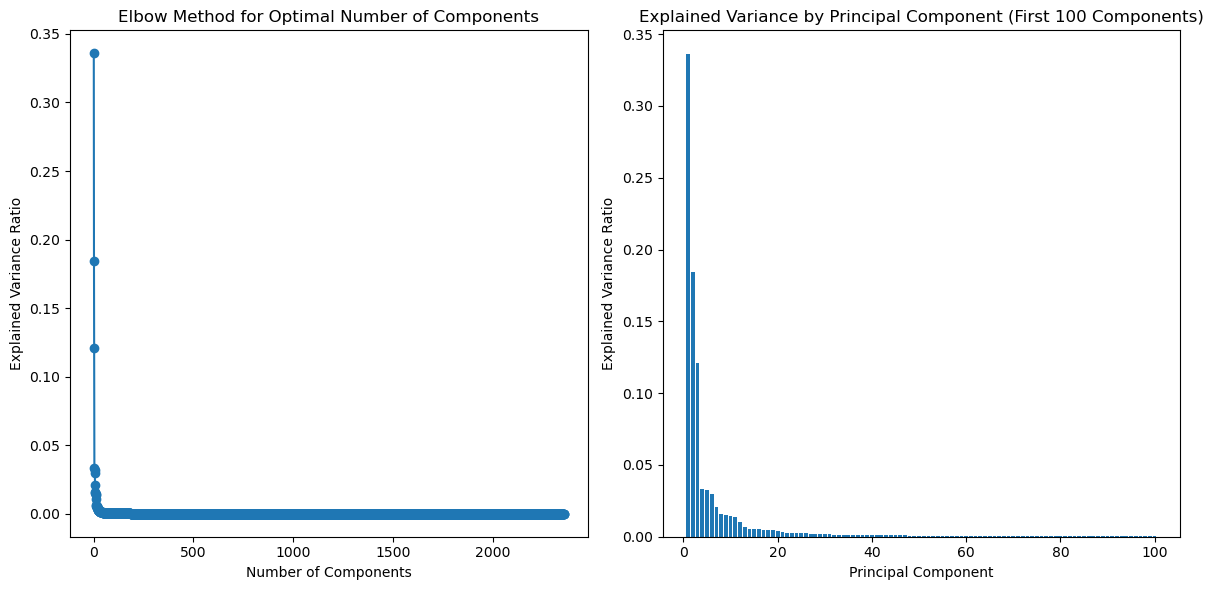

In [28]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate explained variance for different numbers of components
num_components = range(1, min(sample_df.shape[0], sample_df.shape[1]) + 1)
explained_variances = pca.explained_variance_ratio_

# Plot both the elbow curve and the bar plot
plt.figure(figsize=(12, 6))

# Elbow curve
plt.subplot(1, 2, 1)
plt.plot(num_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Method for Optimal Number of Components')

# Bar plot for first 100 components
plt.subplot(1, 2, 2)
plt.bar(range(1, 101), explained_variances[:100], align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component (First 100 Components)')

plt.tight_layout()
plt.show()

# Time and Accuracy vs Complexity

In [29]:
# Dictionary to store results
results = {'Model': [], 'Num_Components': [], 'Accuracy': [], 'Time': []}

# Build classifiers
classifiers = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }
for model_name, model in classifiers.items() :   

    # Run classifiers
    optimal_num_components_list = [10, 20, 30, 40, 50, 60]
    for optimal_num_components in optimal_num_components_list:
    #for model_name, model in classifiers.items():
        pca = PCA(n_components=optimal_num_components)
        pca_result = pca.fit_transform(scaled_data)

        # Create a DataFrame with the principal components
        columns = [f'PC_{i+1}' for i in range(optimal_num_components)]
        pca_df = pd.DataFrame(data=pca_result, columns=columns)

        # Concatenate the original DataFrame with the PCA results
        result_df = pd.concat([sample_df['Melanoma'].reset_index(drop=True), pca_df], axis=1)

        # Split data
        X = result_df.drop(['Melanoma'], axis=1)
        y = result_df['Melanoma']
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        start_time = time.time()
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, pred)
        end_time = time.time()
        elapsed_time = end_time - start_time
        results['Model'].append(model_name)
        results['Num_Components'].append(optimal_num_components)
        results['Accuracy'].append(accuracy)
        results['Time'].append(elapsed_time)

# Create dataframe
classifier_df = pd.DataFrame(results)
classifier_df


,Model,Num_Components,Accuracy,Time
0,Decision Tree,10,0.827259,0.112470
1,Decision Tree,20,0.824264,0.295231
2,Decision Tree,30,0.826760,0.393382
3,Decision Tree,40,0.830754,0.566055
4,Decision Tree,50,0.823764,0.622832
5,Decision Tree,60,0.835746,0.829709
6,SVM,10,0.887169,2.592801
7,SVM,20,0.887668,2.732562
8,SVM,30,0.889166,3.221339
9,SVM,40,0.889166,4.042973


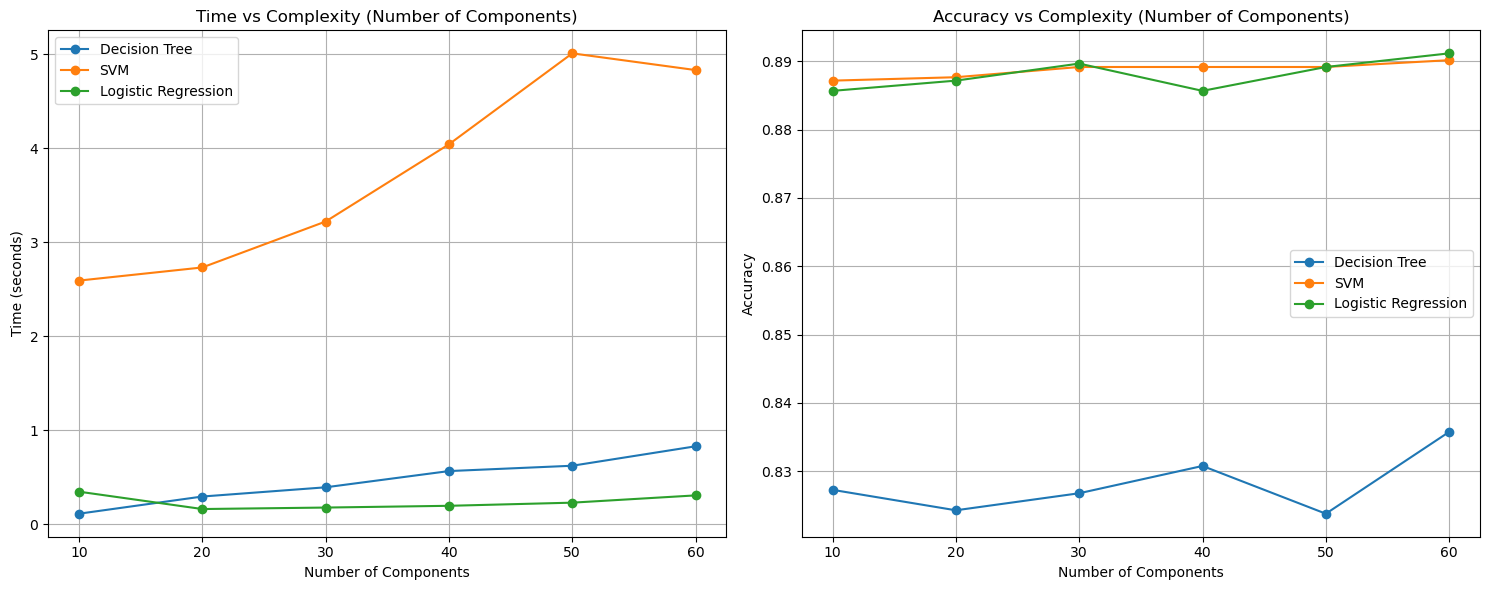

In [30]:
# Plotting
plt.figure(figsize=(15, 6))

# Subplot 1: Time vs Complexity
plt.subplot(1, 2, 1)
for model_name in classifier_df['Model'].unique():
    model_data = classifier_df[classifier_df['Model'] == model_name]
    plt.plot(model_data['Num_Components'], model_data['Time'], marker='o', label=model_name)

plt.title('Time vs Complexity (Number of Components)')
plt.xlabel('Number of Components')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy vs Complexity
plt.subplot(1, 2, 2)
for model_name in classifier_df['Model'].unique():
    model_data = classifier_df[classifier_df['Model'] == model_name]
    plt.plot(model_data['Num_Components'], model_data['Accuracy'], marker='o', label=model_name)

plt.title('Accuracy vs Complexity (Number of Components)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
# Determine the optimal number of components using the elbow point
optimal_num_components = 40

# Apply PCA with the optimal number of components
pca = PCA(n_components=optimal_num_components)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
columns = [f'PC_{i+1}' for i in range(optimal_num_components)]
pca_df = pd.DataFrame(data=pca_result, columns=columns)

# Concatenate the original DataFrame with the PCA results
result_df = pd.concat([sample_df['Melanoma'].reset_index(drop = True), pca_df], axis=1)
#result_df= pca_df.copy()
# Display the result DataFrame
result_df

,Melanoma,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,PC_40
0,0,-27.368606,17.074180,-9.201864,10.134472,2.679746,-3.454460,1.722626,0.550024,3.083997,...,-1.174557,-0.976281,2.476071,1.117240,2.166312,0.591728,-1.247588,-0.394877,-1.574699,3.367644
1,0,-12.059795,35.548879,-24.265885,2.246357,-0.123107,-4.392795,-4.990374,6.666206,-4.759763,...,-0.220184,-1.222639,-1.817118,2.581213,-1.000284,1.212541,-2.853849,-1.399112,1.982335,3.162004
2,0,-21.408628,12.925325,-18.569314,6.594330,2.437873,-6.160212,5.014224,0.037114,-2.999922,...,0.835643,3.773002,-0.163998,1.590715,2.402305,0.373517,-0.824208,-0.292435,0.516403,-1.134967
3,0,6.187694,25.386042,-29.262604,1.658438,0.537325,-0.602798,1.405439,4.756111,-4.235413,...,3.470955,1.296457,-2.269819,1.860398,1.817278,0.703631,-1.352623,2.523926,0.669678,-0.991325
4,0,-43.702779,2.780150,7.501198,-13.321486,33.391933,-2.031908,-4.776041,19.417695,-5.650895,...,2.553352,2.987610,2.220880,7.213584,-7.877829,4.015828,7.009137,0.589928,4.003397,-3.215448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0,-35.396336,2.692618,15.431506,16.728912,4.234796,-5.711776,-2.675322,7.458193,-3.767702,...,2.582289,-1.521038,-3.083673,1.617272,3.493255,-0.207038,-1.206481,-0.728494,-2.435753,0.994143
10011,0,0.128330,30.314711,-10.164569,1.095151,-15.383785,-5.726315,-9.604201,6.003047,5.589776,...,-0.494952,-0.494299,-2.319220,3.062707,-6.121805,-2.110510,4.472931,4.095894,-1.616674,-2.352889
10012,0,-57.863783,20.258730,-4.417633,7.363202,-7.171342,-3.193650,-8.081630,13.824273,-2.322212,...,3.293476,-1.491187,-1.129538,-0.534354,-3.013398,0.045888,5.455325,1.585361,1.878266,0.138471
10013,0,-7.158850,17.497141,-1.920920,-2.352142,15.000712,-3.401251,6.085053,4.969295,-6.863303,...,-1.374444,-3.517125,0.681630,-0.272686,-0.219773,0.354977,0.356493,0.011779,-0.325179,-0.234358


# High Level Fusion

In [36]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Build three classifiers: Decision tree, SVM, and Logistic regression.

#classifier: Decision tree

In [37]:
# Suppose 'label' is the column containing labels
X = result_df.drop(['Melanoma'], axis =1)
y = result_df['Melanoma']

# Split into train(80%) and test(20%) sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build three classifiers: Decision tree, SVM, and Logistic regression.
DT = DecisionTreeClassifier()
SVM = SVC(probability=True)  # Set probability=True
LR = LogisticRegression(max_iter=1000)

Decision Tree Accuracy: 0.8227658512231653


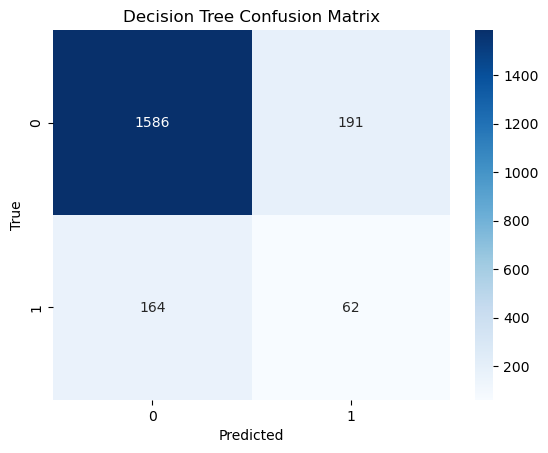

Decision Tree Metrics:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1777
           1       0.25      0.27      0.26       226

    accuracy                           0.82      2003
   macro avg       0.58      0.58      0.58      2003
weighted avg       0.83      0.82      0.83      2003



In [41]:
# Check performance of classifiers
DT.fit(x_train, y_train)
pred_dt = DT.predict(x_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, pred_dt))

# Plot confusion matrix for Decision Tree
plot_confusion_matrix(y_test, pred_dt, 'Decision Tree Confusion Matrix')

print("Decision Tree Metrics:")
print(classification_report(y_test, pred_dt))

#classifier: SVM

SVM Accuracy: 0.889166250624064


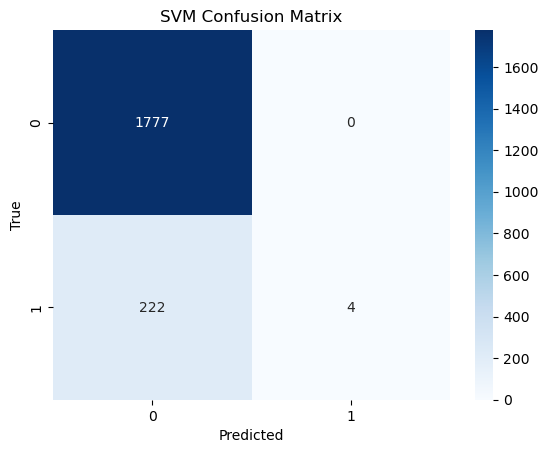

SVM Metrics:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1777
           1       1.00      0.02      0.03       226

    accuracy                           0.89      2003
   macro avg       0.94      0.51      0.49      2003
weighted avg       0.90      0.89      0.84      2003



In [42]:
#Fit Svm Model
SVM.fit(x_train, y_train)
pred_svm = SVM.predict(x_test)
print("SVM Accuracy:", accuracy_score(y_test, pred_svm))

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, pred_svm, 'SVM Confusion Matrix')

print("SVM Metrics:")
print(classification_report(y_test, pred_svm))


#classifier: Logistic Regression

Logistic Regression Accuracy: 0.8846729905142287


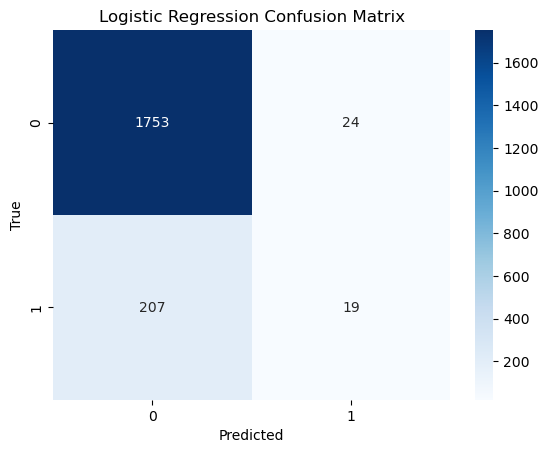

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1777
           1       0.44      0.08      0.14       226

    accuracy                           0.88      2003
   macro avg       0.67      0.54      0.54      2003
weighted avg       0.84      0.88      0.85      2003



In [43]:
#Fit Logistic Regression Model
LR.fit(x_train, y_train)
pred_lr = LR.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr))

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, pred_lr, 'Logistic Regression Confusion Matrix')

print("Logistic Regression Metrics:")
print(classification_report(y_test, pred_lr))

# Bayesian Consensus (High Level Fusion)

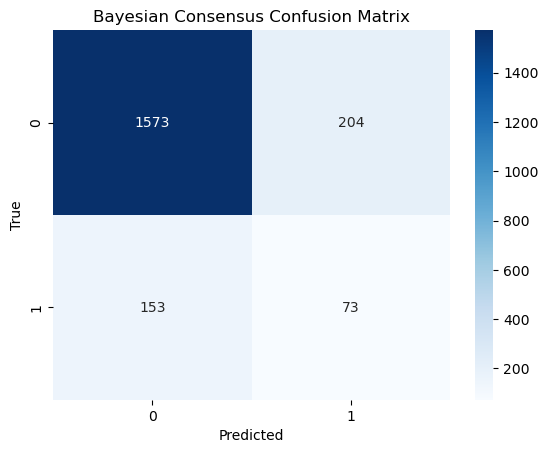

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1777
           1       0.26      0.32      0.29       226

    accuracy                           0.82      2003
   macro avg       0.59      0.60      0.59      2003
weighted avg       0.84      0.82      0.83      2003



In [44]:
class Bayesian_Consensus():

    def __init__(self, y_true, *y_pred):

        self.y_true = y_true
        self.y_pred = y_pred
        self.con_matrices = [confusion_matrix(y_true, pred, normalize='true') for pred in y_pred]

    def calculate_result(self, pred_values):

        if set(pred_values).issubset({0, 1}):
            pass
        else:
            raise ValueError("This function can only take in binary values in a list")

        pos_prob = 0.5
        neg_prob = 0.5

        for con, pred_value in zip(self.con_matrices, pred_values):
            pos_prob = con[1, pred_value] * pos_prob / (con[1, pred_value] * pos_prob + con[0, pred_value] * neg_prob)
            neg_prob = 1 - pos_prob

        return 1 if pos_prob > neg_prob else 0


bayesian = Bayesian_Consensus(y_test, pred_dt, pred_svm, pred_lr)

y_pred_final = [bayesian.calculate_result(pr) for pr in zip(pred_dt, pred_svm, pred_lr)]
y_pred_final

plot_confusion_matrix(y_test, y_pred_final, 'Bayesian Consensus Confusion Matrix')
print(classification_report(y_test, y_pred_final))


In [45]:
print("Bayesian Consensus Accuracy:", accuracy_score(y_test, y_pred_final))

Bayesian Consensus Accuracy: 0.8217673489765353


# Federated Learning

In [98]:
#dataset

In [100]:
# X = result_df[result_df.columns[2354:-1].values]
X = sample_df.drop(['Melanoma'], axis =1)
y = sample_df['Melanoma']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

x1 = x_train.iloc[:, :4].values
x2 = x_train.iloc[:, 4:].values

x1_test = x_test.iloc[:, :4].values
x2_test = x_test.iloc[:, 4:].values


In [101]:
#model

In [103]:
import numpy as np
from scipy.special import expit

class LogisticRegressionModel:
    """
    Implementation of Logistic Regression for Vertical Federated Learning.
    """
    def __init__(self, data: np.ndarray, lr: float, seed: int = 12345):
        """
        Initialize the logistic regression model.

        Parameters:
        data (np.ndarray): The input data.
        lr (float): Learning rate for the model.
        seed (int): Random seed for reproducibility.
        """
        np.random.seed(seed)
        x=data
        self.lr = lr
        self.m, self.n = data.shape
        self.w = np.random.normal(loc=0.0, scale=1.0, size=(self.n, 1))
        self.b = 0
        self.dw = None
        self.db = None
    
    def normalize(self, X: np.ndarray) -> np.ndarray:
        return (X - X.mean(axis=0)) / X.std(axis=0)

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        return expit(z)
       
    
    def loss(self, y: np.ndarray, y_hat: np.ndarray) -> float:
        """
        Compute the logistic loss.

        Parameters:
        y (np.ndarray): True labels.
        y_hat (np.ndarray): Predicted labels.

        Returns:
        float: Computed loss.
        """
        epsilon = 1e-15  
        loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        return loss
    
    def gradients(self, X: np.ndarray, diff: np.ndarray) -> tuple:
        """Compute and return the gradients."""
        dw = (1 / self.m) * np.dot(X.T, diff)
        db = (1 / self.m) * np.sum(diff)
        return dw, db
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward pass."""
        self.x=x
        z = np.dot(self.x, self.w) + self.b
        return z
    
    def compute_diff(self, z: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the difference between predicted and true labels."""
        y_hat = self.sigmoid(z)
        diff = y_hat - y
        return diff
    
    def compute_gradient(self,diff: np.ndarray):
  
        self.dw, self.db = self.gradients(self.x, diff)
        return self.dw,self.db
    
    def update_model_(self, y: np.ndarray) -> float:
        """Update the model parameters and return the loss."""
        self.w -= self.lr * self.dw
        self.b -= self.lr * self.db
        l = self.loss(y, self.sigmoid(np.dot(self.x, self.w) + self.b))
        return l
        
    def update_model(self):
        """Update the model parameters."""
        self.w -= self.lr * self.dw
        self.b -= self.lr * self.db
        
    def get_gradients(self) -> tuple:
        """Return the gradients if they exist."""
        if self.dw is not None and self.db is not None:
            return self.dw, self.db
        else:
            return None
    
    def predict(self, X):
        if len(self.w.shape) == 1:
            self.w = self.w.reshape(-1, 1)

        
        preds = self.sigmoid(np.dot(X, self.w) + self.b)
        pred_class = [1 if i > 0.5 else 0 for i in preds]
        return np.array(pred_class).reshape(-1, 1)
    

        
   

In [104]:
#client

In [105]:
from abc import ABC, abstractmethod

class ClientInterface(ABC):


    @abstractmethod
    def receive(self, data) -> None:
        pass
    
    @abstractmethod
    def send(self) -> None:
       
        pass
    
    @abstractmethod
    def compute_gradient(self) -> None:
       
        pass

In [230]:
#host

In [107]:
class Host(ClientInterface):
    """
    Implementation of a passive party (Host) in a vertical federated learning system.
    """
    def __init__(self, lr: float, model_instance: LogisticRegressionModel, data: np.ndarray):
        """
        Initializes the Host instance.

        Parameters:
        lr (float): Learning rate.
        model_instance (model): Instance of the logistic regression model.
        data (np.ndarray): Data for the host.
        """
        self.lr = lr
        self.x = data
        self.model = model_instance(self.x, self.lr)
        self.z = None
        self.diff = None

    def create_batch(self, ids: List[int]) -> np.ndarray:
        """Creates a batch of data using the provided ids."""
        return np.array([self.x[id] for id in ids])

    def forward(self, ids: List[int]):
        """Performs a forward pass using the data associated with the provided ids."""
        x = self.create_batch(ids)
        self.z = self.model.forward(x)

    def receive(self, diff: np.ndarray):
        """Receives diff from the active party (Guest)."""
        self.diff = diff

    def send(self) -> np.ndarray:
        """Sends computed z to the active party (Guest)."""
        return self.z

    def compute_gradient(self):
        """Computes the gradient based on received diff and local parameters."""
        self.dw, self.db = self.model.compute_gradient(self.diff)

    def update_model(self):
        """Updates the model parameters."""
        self.model.update_model()

    def compute_contribution(self, X_host):
            # X_host is the input features available to the Host
            return np.dot(X_host, self.model.w) + self.model.b

In [108]:
#guest

In [109]:
class Guest(ClientInterface):
    """
    Implementation of the active party (Guest) in a federated learning system.
    """
    def __init__(self, lr: float, model_instance: LogisticRegressionModel, data: Tuple[np.ndarray, np.ndarray]):
        """
        Initializes the Guest instance.

        Parameters:
        lr (float): Learning rate.
        model_instance (model): Instance of the logistic regression model.
        data (Tuple[np.ndarray, np.ndarray]): Tuple containing features and labels.
        """
        self.lr = lr
        self.x, self.y = data
        self.y = self.y.reset_index(drop=True) 
        self.model = model_instance(self.x, self.lr)
        self.z = None
        self.diff = None

    def create_batch(self, ids: List[int]) -> np.ndarray:
        """Creates a batch of data using the provided ids."""
        self.y_ = np.array([self.y[id] for id in ids]).reshape(-1, 1)
        return np.array([self.x[id] for id in ids])

    def forward(self, ids: List[int]):
        """Performs a forward pass using the data associated with the provided ids."""
        x = self.create_batch(ids)
        
        self.z = self.model.forward(x)

    def normalize(self, X: np.ndarray) -> np.ndarray:
        """Normalizes the input data."""
        return (X - X.mean(axis=0)) / X.std(axis=0)

    # def receive(self, z1: np.ndarray, z2: np.ndarray):
    def receive(self, z1: np.ndarray):
        """Receives data from passive parties and updates z."""
        self.z += z1 #+ z2

    def compute_gradient(self):
        """Computes the gradient based on received data and local parameters."""
       
        self.diff = self.model.compute_diff(self.z, self.y_)
        self.dw, self.db = self.model.compute_gradient(self.diff)

    def send(self) -> np.ndarray:
        """Sends computed diff to other parties."""
        return self.diff

    def update_model(self):
        """Updates the model parameters and computes the loss."""
        self.loss = self.model.update_model_(self.y_)

    def predict(self, X_guest, host_contributions):
        # X_guest is the input features available to the Guest
        z_guest = np.dot(X_guest, self.model.w) + self.model.b
        # Sum up contributions from all hosts
        z_total = z_guest + sum(host_contributions)
        prob = self.model.sigmoid(z_total)
        predictions = [1 if p >= 0.5 else 0 for p in prob]
        return predictions

    def predict_local(self, X_guest):
        # X_guest is the input features available to the Guest
        z_guest = np.dot(X_guest, self.model.w) + self.model.b
        prob = self.model.sigmoid(z_guest)
        predictions = [1 if p >= 0.5 else 0 for p in prob]
        return predictions   
        

In [110]:
#broker

Local Model Accuracy of Guest:  0.8346645367412141
Local Model F1 Score of Guest:  0.009569377990430622
Local Report               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2212
           1       0.02      0.01      0.01       292

    accuracy                           0.83      2504
   macro avg       0.45      0.48      0.46      2504
weighted avg       0.78      0.83      0.80      2504

Federated Model Accuracy of Guest:  0.8833865814696485
Federated Model F1 Score of Guest:  0.0
Federated Report               precision    recall  f1-score   support

           0       0.88      1.00      0.94      2212
           1       0.00      0.00      0.00       292

    accuracy                           0.88      2504
   macro avg       0.44      0.50      0.47      2504
weighted avg       0.78      0.88      0.83      2504



/Users/murad/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/murad/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/murad/anaconda/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

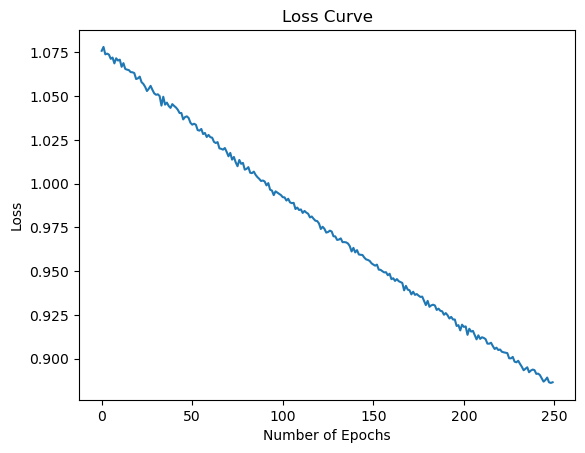

In [95]:
# Constants
NUM_CLIENTS = 2
BATCH_SIZE = 50
COMM_ROUNDS = 250

    
def generate_batch_ids(limit, n_samples, batch_size, seen_samples):
    ids = [e for e in random.sample(range(limit), n_samples) if e not in seen_samples]
    seen_samples.update(ids[:batch_size])
    return ids[:batch_size]

def main(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    x1 = x_train.iloc[:, :4].values
    x2 = x_train.iloc[:, 4:].values

    x1_test = x_test.iloc[:, :4].values
    x2_test = x_test.iloc[:, 4:].values

    y= y_train
    N = x1.shape[0]
    num_batch = N // BATCH_SIZE
    
    guest = Guest(0.0001, LogisticRegressionModel, data=(x1, y))
    host1 = Host(0.0001, LogisticRegressionModel, data=x2)

    loss_per_epoch = []

    for r in range(COMM_ROUNDS):
        seen_samples = set()
        losses = []
        for _ in range(num_batch):
            ids = generate_batch_ids(N, N, BATCH_SIZE, seen_samples)
            guest.forward(ids)
            host1.forward(ids)

            guest.receive(host1.send())
            guest.compute_gradient()

            diff = guest.send()
            host1.receive(diff)

            host1.compute_gradient()
            guest.update_model()
            host1.update_model()

            losses.append(guest.loss)

        
        epoch_loss = sum(losses) / len(losses) if losses else 0
        loss_per_epoch.append(epoch_loss)


    
    predictions_local = guest.predict_local(x1_test)
    print("Local Model Accuracy of Guest: ",accuracy_score(y_test,predictions_local))
    print("Local Model F1 Score of Guest: ",f1_score(y_test,predictions_local))
    print("Local Report",classification_report(y_test,predictions_local))

    # The guest receives the contributions and makes the final prediction
    host1_contribution = host1.compute_contribution(x2_test)
    predictions = guest.predict(x1_test, host1_contribution)
    print("Federated Model Accuracy of Guest: ",accuracy_score(y_test,predictions))
    print("Federated Model F1 Score of Guest: ",f1_score(y_test,predictions))
    print("Federated Report",classification_report(y_test,predictions))

    plot_loss(loss_per_epoch)


def plot_loss(loss_per_epoch):
    plt.plot(loss_per_epoch)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

if __name__ == "__main__":
    main(X,y)
    